In [1]:
%pip install numpy -q
%pip install qiskit -q
%pip install scipy -q
%pip install matplotlib -q
%pip install qiskit-ibm-runtime -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Necessary libraries
import numpy as np
import time

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator

from scipy.optimize import minimize

import matplotlib.pyplot as plt

## Defining the Problem Hamiltonian

In [246]:
# Defining the Hamiltonian of the problem
Jx, Jy, Jz = 1.2, 1.3, 1.4
hx, hy, hz = 0,0,0

# Correcting all coefficients to match the problem hamiltonian
Jx *= -0.5
Jy *= -0.5
Jz *= -0.5
hx *= -0.5
hy *= -0.5
hz *= -0.5

lattice_size = 5

hamiltonian = []

# Addition of interaction term and extrernal magnetic field
for qubit_no in range(lattice_size):
    if qubit_no == lattice_size - 1:
        interaction_term = [("X" + "I" * (lattice_size - 2) + "X", Jx),
                            ("Y" + "I" * (lattice_size - 2) + "Y", Jy),
                            ("Z" + "I" * (lattice_size - 2) + "Z", Jz)]
    else:
        interaction_term = [("I" * qubit_no + "XX" + "I" * (lattice_size - qubit_no - 2), Jx),
                            ("I" * qubit_no + "YY" + "I" * (lattice_size - qubit_no - 2), Jy),
                            ("I" * qubit_no + "ZZ" + "I" * (lattice_size - qubit_no - 2), Jz)]

    magnetic_term = [("I" * qubit_no + "X" + "I" * (lattice_size - qubit_no - 1), hx),
                     ("I" * qubit_no + "Y" + "I" * (lattice_size - qubit_no - 1), hy),
                     ("I" * qubit_no + "Z" + "I" * (lattice_size - qubit_no - 1), hz)]
    hamiltonian = hamiltonian + interaction_term + magnetic_term

hamiltonian = SparsePauliOp.from_list(hamiltonian)

## Making the Ansatz

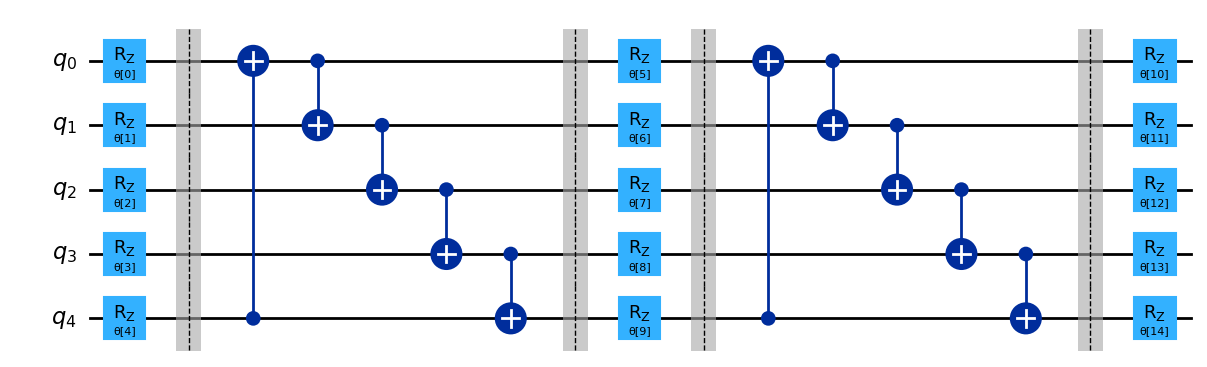

In [286]:
ansatz1 = TwoLocal(num_qubits= hamiltonian.num_qubits,
                  rotation_blocks= "rz",
                  entanglement_blocks= "cx",
                  entanglement= "circular",
                  reps= 2,
                  insert_barriers= True)
ansatz1.decompose().draw("mpl", style="iqp")

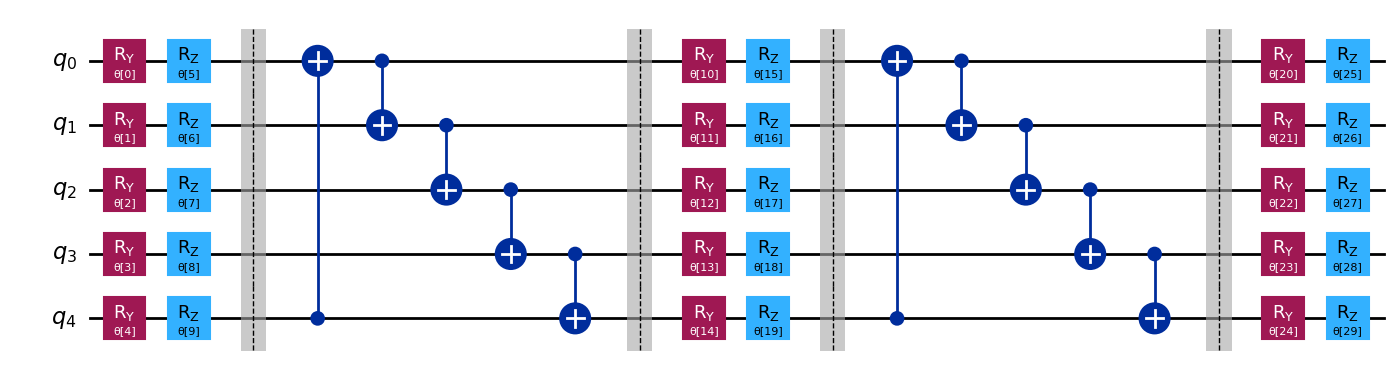

In [248]:
ansatz2 = EfficientSU2(num_qubits= hamiltonian.num_qubits,
                       entanglement= "circular",
                       reps= 2,
                       insert_barriers= True)
ansatz2.decompose().draw("mpl", style="iqp")

In [249]:
def uccsd_ansatz(n_qubits):
    qc = QuantumCircuit(n_qubits)
    num_params = n_qubits * (n_qubits - 1) + int((1/6) * n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits -3)) + 1
    params = ParameterVector("θ",num_params)

    param_counter = 0

    # Apply single excitations
    for i in range(n_qubits):
        for j in range(i+1,n_qubits):
            for k in range(i):
                qc.z(k)
            qc.ry(params[param_counter],i)
            param_counter += 1
            for k in range(j):
                qc.z(k)
            qc.rx(params[param_counter],j)
            param_counter += 1

        
    # Apply double excitations (simplified version)
    for i in range(n_qubits):
        for j in range(i+1,n_qubits):
            for k in range(j+1,n_qubits):
                for l in range(k+1,n_qubits):
                    for m in range(i):
                        qc.z(m)
                    qc.ry(params[param_counter],i)
                    param_counter += 1
                    for m in range(j):
                        qc.z(m)
                    qc.ry(params[param_counter],j)
                    param_counter += 1
                    for m in range(k):
                        qc.z(m)
                    qc.rx(params[param_counter],k)
                    param_counter += 1
                    for m in range(l):
                        qc.z(m)
                    qc.rx(params[param_counter],l)
                    param_counter += 1
    
    return qc

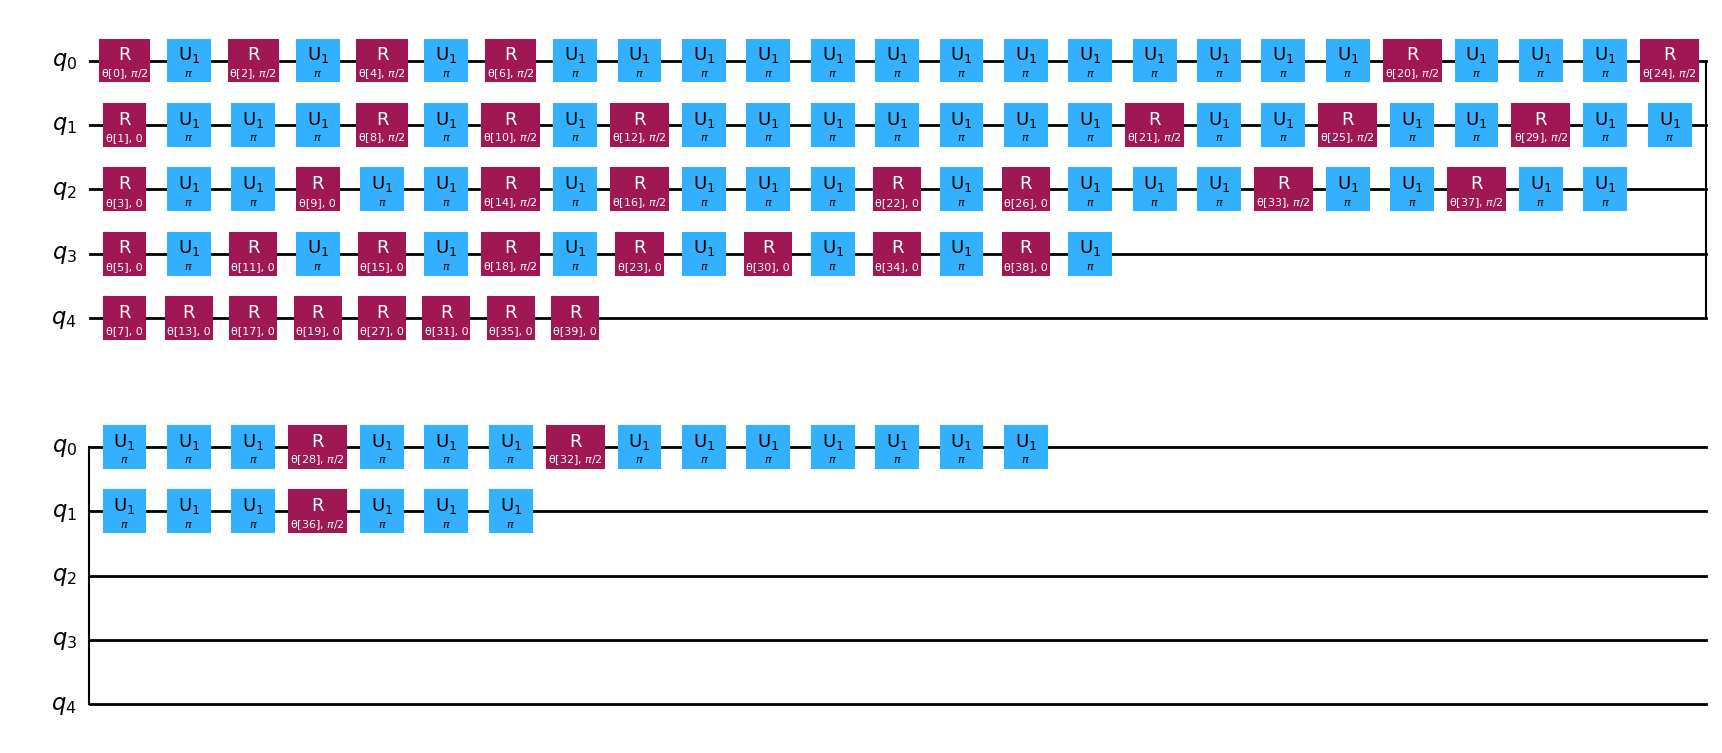

In [250]:
ansatz3 = uccsd_ansatz(n_qubits= lattice_size)
ansatz3.decompose().draw("mpl", style="iqp")

## Simulation Using AerSimulator

In [251]:
classical_backend = AerSimulator()
estimator = StatevectorEstimator()

target = classical_backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

### ISA Conversion


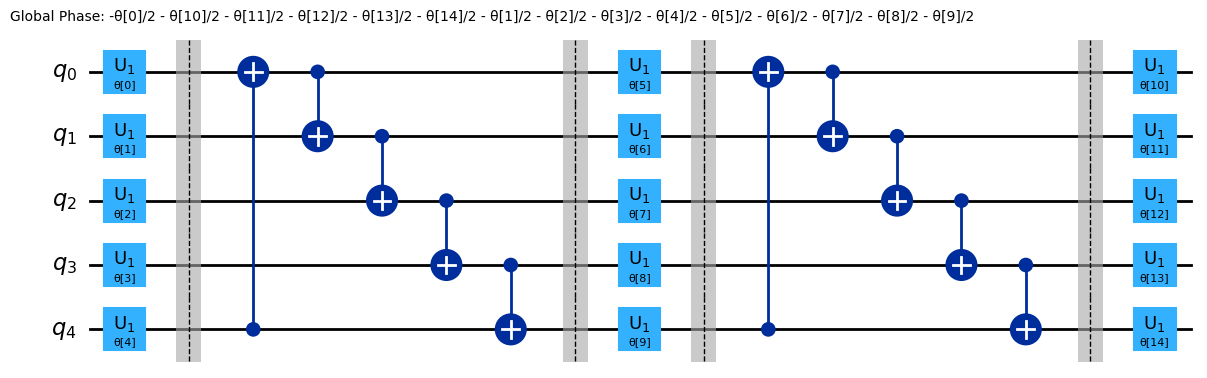

In [252]:
ansatz_isa1 = pm.run(ansatz1)
hamiltonian_isa1 = hamiltonian.apply_layout(layout=ansatz_isa1.layout)
ansatz_isa1.decompose().draw("mpl", style="iqp", idle_wires= False)

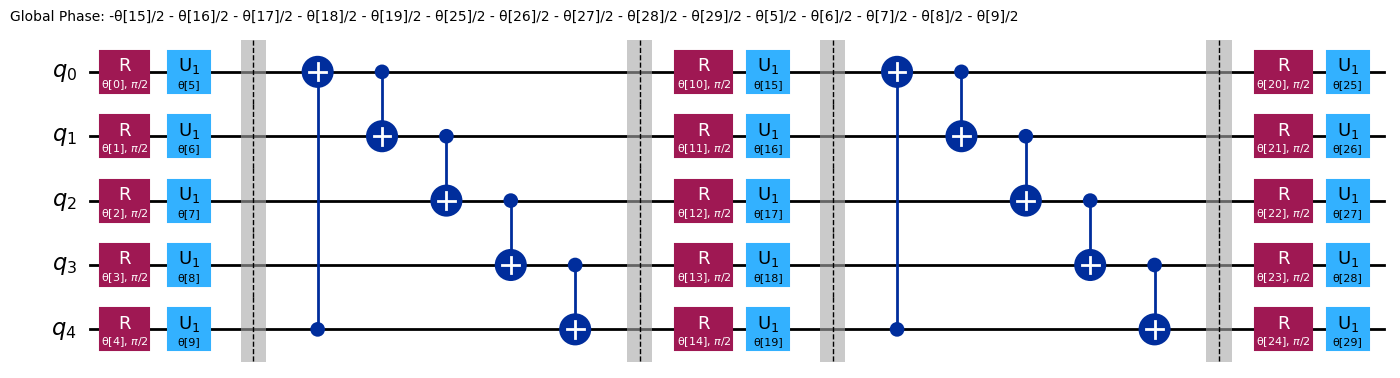

In [253]:
ansatz_isa2 = pm.run(ansatz2)
hamiltonian_isa2 = hamiltonian.apply_layout(layout=ansatz_isa2.layout)
ansatz_isa2.decompose().draw("mpl", style="iqp", idle_wires= False)

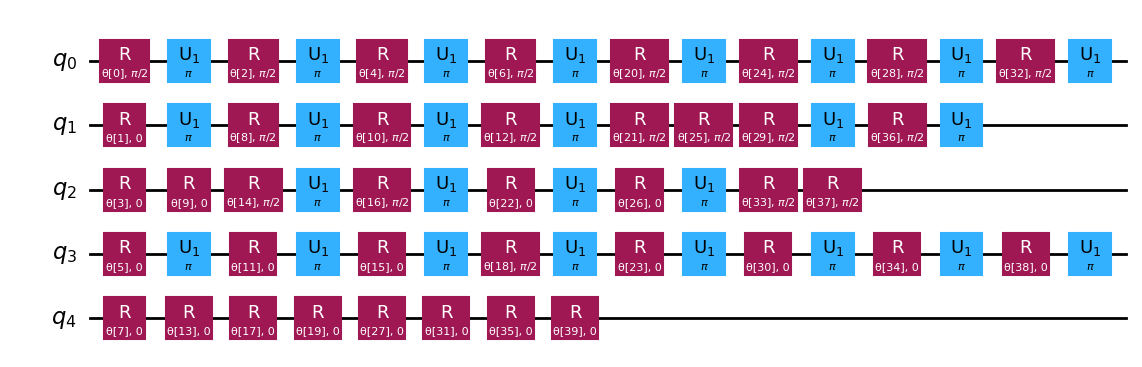

In [254]:
ansatz_isa3 = pm.run(ansatz3)
hamiltonian_isa3 = hamiltonian.apply_layout(layout=ansatz_isa3.layout)
ansatz_isa3.decompose().draw("mpl", style="iqp", idle_wires= False)

### Cost Function

In [255]:
def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs= [pub], precision=1e-6).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    if cost_history_dict["iters"] % 100 == 0:
        print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [263]:
rng = np.random.default_rng(10002)
epochs = 10

### Using TwoLocal()

For Conjugate Gradient Method

In [264]:
time_array_1a = []
iter_array_1a = []
accuracy_array_1a = []

for epoch in range(epochs):    
    cost_history_dict_1a = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "time": 0
    }

    x0 = 2 * np.pi * rng.random(ansatz1.num_parameters)

    start_time = time.time()
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa1, hamiltonian_isa1, estimator, cost_history_dict_1a),
        method="cg",
        tol= 1e-6
    )
    end_time = time.time()

    cost_history_dict_1a["time"]= end_time - start_time
    print(cost_history_dict_1a["time"])
    time_array_1a.append(cost_history_dict_1a["time"])
    iter_array_1a.append(cost_history_dict_1a["iters"])
    accuracy_array_1a.append(np.array(cost_history_dict_1a["cost_history"]).mean())

print(time_array_1a)
print(iter_array_1a)
print(accuracy_array_1a)

average_time_1a = np.array(time_array_1a).mean()
var_time_1a = np.array(time_array_1a).var()
average_iter_1a = np.array(iter_array_1a).mean()
var_iter_1a = np.array(iter_array_1a).var()
average_energy_1a = np.array(accuracy_array_1a).mean()
var_energy_1a = np.array(accuracy_array_1a).var()

Iters. done: 100 [Current cost: -3.4999993259520523]
Iters. done: 200 [Current cost: -3.499999905303753]
Iters. done: 300 [Current cost: -3.4999985613446865]
2.3272721767425537
Iters. done: 100 [Current cost: -3.50000027538085]
Iters. done: 200 [Current cost: -3.50000090570111]
Iters. done: 300 [Current cost: -3.500000100339464]
2.6140639781951904
Iters. done: 100 [Current cost: -3.500000059128699]
Iters. done: 200 [Current cost: -3.499998990564356]
Iters. done: 300 [Current cost: -3.4999992385253904]
Iters. done: 400 [Current cost: -3.499999070212244]
Iters. done: 500 [Current cost: -3.499999998129812]
3.398000478744507
Iters. done: 100 [Current cost: -3.4999994076816705]
Iters. done: 200 [Current cost: -3.500000309639179]
Iters. done: 300 [Current cost: -3.4999993591900846]
2.5351617336273193
Iters. done: 100 [Current cost: -3.5000007070136148]
Iters. done: 200 [Current cost: -3.5000004256393944]
Iters. done: 300 [Current cost: -3.5000008753663288]
2.619661569595337
Iters. done: 100 

### For Powell Method

In [265]:
time_array_1b = []
iter_array_1b = []
accuracy_array_1b = []

for epoch in range(epochs):    
    cost_history_dict_1b = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "time": 0
    }

    x0 = 2 * np.pi * rng.random(ansatz1.num_parameters)

    start_time = time.time()
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa1, hamiltonian_isa1, estimator, cost_history_dict_1b),
        method="powell",
        tol= 1e-6
    )
    end_time = time.time()

    cost_history_dict_1b["time"]= end_time - start_time
    print(cost_history_dict_1b["time"])
    time_array_1b.append(cost_history_dict_1b["time"])
    iter_array_1b.append(cost_history_dict_1b["iters"])
    accuracy_array_1b.append(np.array(cost_history_dict_1b["cost_history"]).mean())

print(time_array_1b)
print(iter_array_1b)
print(accuracy_array_1b)

average_time_1b = np.array(time_array_1b).mean()
var_time_1b = np.array(time_array_1b).var()
average_iter_1b = np.array(iter_array_1b).mean()
var_iter_1b = np.array(iter_array_1b).var()
average_energy_1b = np.array(accuracy_array_1b).mean()
var_energy_1b= np.array(accuracy_array_1b).var()

Iters. done: 100 [Current cost: -3.500000449770666]
Iters. done: 200 [Current cost: -3.5000004592884943]
Iters. done: 300 [Current cost: -3.4999990645202725]
1.8432056903839111
Iters. done: 100 [Current cost: -3.5000007428640574]
Iters. done: 200 [Current cost: -3.5000005557624467]
Iters. done: 300 [Current cost: -3.500000146918841]
2.801706075668335
Iters. done: 100 [Current cost: -3.499999199066152]
Iters. done: 200 [Current cost: -3.4999992366422337]
Iters. done: 300 [Current cost: -3.5000009427548027]
2.082636833190918
Iters. done: 100 [Current cost: -3.4999995837322606]
Iters. done: 200 [Current cost: -3.4999995812866427]
Iters. done: 300 [Current cost: -3.499999057938832]
2.3100597858428955
Iters. done: 100 [Current cost: -3.499998895161655]
Iters. done: 200 [Current cost: -3.5000001041385143]
Iters. done: 300 [Current cost: -3.50000026729758]
2.4207866191864014
Iters. done: 100 [Current cost: -3.4999985042809247]
Iters. done: 200 [Current cost: -3.5000005729976187]
Iters. done: 

## Using EfficientSu2

### For Conjugate Gradient Method

In [266]:
time_array_2a = []
iter_array_2a = []
accuracy_array_2a = []

for epoch in range(epochs):    
    cost_history_dict_2a = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "time": 0
    }

    x0 = 2 * np.pi * rng.random(ansatz2.num_parameters)

    start_time = time.time()
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa2, hamiltonian_isa2, estimator, cost_history_dict_2a),
        method="cg",
        tol= 1e-6
    )
    end_time = time.time()

    cost_history_dict_2a["time"]= end_time - start_time
    print(cost_history_dict_2a["time"])
    time_array_2a.append(cost_history_dict_2a["time"])
    iter_array_2a.append(cost_history_dict_2a["iters"])
    accuracy_array_2a.append(np.array(cost_history_dict_2a["cost_history"]).mean())

print(time_array_2a)
print(iter_array_2a)
print(accuracy_array_2a)

average_time_2a = np.array(time_array_2a).mean()
var_time_2a = np.array(time_array_2a).var()
average_iter_2a = np.array(iter_array_2a).mean()
var_iter_2a = np.array(iter_array_2a).var()
average_energy_2a = np.array(accuracy_array_2a).mean()
var_energy_2a = np.array(accuracy_array_2a).var()

Iters. done: 100 [Current cost: 0.023469664154087837]
Iters. done: 200 [Current cost: 0.02273528780701701]
Iters. done: 300 [Current cost: 0.02273402194326296]
Iters. done: 400 [Current cost: 0.02273334487529161]
Iters. done: 500 [Current cost: 0.022733028373924744]
Iters. done: 600 [Current cost: 0.02273412227350083]
5.119920969009399
Iters. done: 100 [Current cost: -0.16128646977552694]
Iters. done: 200 [Current cost: -0.16169653878680573]
Iters. done: 300 [Current cost: -0.16169482151956083]
Iters. done: 400 [Current cost: -0.16169524364691837]
Iters. done: 500 [Current cost: -0.16169517720094514]
3.8780455589294434
Iters. done: 100 [Current cost: 0.20693528027882982]
Iters. done: 200 [Current cost: 0.16021589155821836]
Iters. done: 300 [Current cost: 0.1593408141845802]
Iters. done: 400 [Current cost: 0.15931578583268047]
Iters. done: 500 [Current cost: 0.15931606412309549]
Iters. done: 600 [Current cost: 0.1593166887515286]
Iters. done: 700 [Current cost: 0.15931686129991232]
Iter

### For Powell Method


In [267]:
time_array_2b = []
iter_array_2b = []
accuracy_array_2b = []

for epoch in range(epochs):    
    cost_history_dict_2b = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "time": 0
    }

    x0 = 2 * np.pi * rng.random(ansatz2.num_parameters)

    start_time = time.time()
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa2, hamiltonian_isa2, estimator, cost_history_dict_2b),
        method="powell",
        tol= 1e-6
    )
    end_time = time.time()

    cost_history_dict_2b["time"]= end_time - start_time
    print(cost_history_dict_2b["time"])
    time_array_2b.append(cost_history_dict_2b["time"])
    iter_array_2b.append(cost_history_dict_2b["iters"])
    accuracy_array_2b.append(np.array(cost_history_dict_2b["cost_history"]).mean())

print(time_array_2b)
print(iter_array_2b)
print(accuracy_array_2b)

average_time_2b = np.array(time_array_2b).mean()
var_time_2b = np.array(time_array_2b).var()
average_iter_2b = np.array(iter_array_2b).mean()
var_iter_2b = np.array(iter_array_2b).var()
average_energy_2b = np.array(accuracy_array_2b).mean()
var_energy_2b = np.array(accuracy_array_2b).var()

Iters. done: 100 [Current cost: -1.2514840158387974]
Iters. done: 200 [Current cost: -1.8476366142023877]
Iters. done: 300 [Current cost: -1.952704959077773]
Iters. done: 400 [Current cost: -2.3080268701573914]
Iters. done: 500 [Current cost: -2.486026113497434]
Iters. done: 600 [Current cost: -2.6891486952488277]
Iters. done: 700 [Current cost: -2.8646742384989388]
Iters. done: 800 [Current cost: -2.297541651527813]
Iters. done: 900 [Current cost: -3.095216300035846]
Iters. done: 1000 [Current cost: -3.1920487869835634]
Iters. done: 1100 [Current cost: -3.2716494239184617]
Iters. done: 1200 [Current cost: -3.322314807442221]
Iters. done: 1300 [Current cost: -3.3552034651550535]
Iters. done: 1400 [Current cost: -3.3692288246804]
Iters. done: 1500 [Current cost: -3.376926985263191]
Iters. done: 1600 [Current cost: -2.803512233634857]
Iters. done: 1700 [Current cost: -3.423988293728434]
Iters. done: 1800 [Current cost: -3.43983579030097]
Iters. done: 1900 [Current cost: -3.44622895488656

## Using UCCSD()

### For Conjugate Gradient Method

In [268]:
time_array_3a = []
iter_array_3a = []
accuracy_array_3a = []

for epoch in range(epochs):    
    cost_history_dict_3a = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "time": 0
    }

    x0 = 2 * np.pi * rng.random(ansatz3.num_parameters)

    start_time = time.time()
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa3, hamiltonian_isa3, estimator, cost_history_dict_3a),
        method="cg",
        tol= 1e-6
    )
    end_time = time.time()

    cost_history_dict_3a["time"]= end_time - start_time
    print(cost_history_dict_3a["time"])
    time_array_3a.append(cost_history_dict_3a["time"])
    iter_array_3a.append(cost_history_dict_3a["iters"])
    accuracy_array_3a.append(np.array(cost_history_dict_3a["cost_history"]).mean())

print(time_array_3a)
print(iter_array_3a)
print(accuracy_array_3a)

average_time_3a = np.array(time_array_3a).mean()
var_time_3a = np.array(time_array_3a).var()
average_iter_3a = np.array(iter_array_3a).mean()
var_iter_3a = np.array(iter_array_3a).var()
average_energy_3a = np.array(accuracy_array_3a).mean()
var_energy_3a = np.array(accuracy_array_3a).var()

Iters. done: 100 [Current cost: 0.3908157483584192]
Iters. done: 200 [Current cost: 0.21992035991135964]
Iters. done: 300 [Current cost: 0.20226674122508828]
Iters. done: 400 [Current cost: 0.20183163969110246]
Iters. done: 500 [Current cost: 0.2017416004656118]
Iters. done: 600 [Current cost: 0.2017359105735432]
Iters. done: 700 [Current cost: 0.20173384988198498]
Iters. done: 800 [Current cost: 0.20173327507783173]
Iters. done: 900 [Current cost: 0.20173541530541175]
Iters. done: 1000 [Current cost: 0.20173492744150312]
11.217949867248535
Iters. done: 100 [Current cost: 0.44107615011699264]
Iters. done: 200 [Current cost: 0.4386745239507732]
Iters. done: 300 [Current cost: 0.43867356335866764]
Iters. done: 400 [Current cost: 0.43867373346793226]
Iters. done: 500 [Current cost: 0.4386704893423195]
Iters. done: 600 [Current cost: 0.4386732477655091]
Iters. done: 700 [Current cost: 0.4386728656873467]
Iters. done: 800 [Current cost: 0.4386720061546034]
Iters. done: 900 [Current cost: 0.

### For Powell Method

In [269]:
time_array_3b = []
iter_array_3b = []
accuracy_array_3b = []

for epoch in range(epochs):    
    cost_history_dict_3b = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        "time": 0
    }

    x0 = 2 * np.pi * rng.random(ansatz3.num_parameters)

    start_time = time.time()
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa3, hamiltonian_isa3, estimator, cost_history_dict_3b),
        method="powell",
        tol= 1e-6
    )
    end_time = time.time()

    cost_history_dict_3b["time"]= end_time - start_time
    print(cost_history_dict_3b["time"])
    time_array_3b.append(cost_history_dict_3b["time"])
    iter_array_3b.append(cost_history_dict_3b["iters"])
    accuracy_array_3b.append(np.array(cost_history_dict_3b["cost_history"]).mean())

print(time_array_3b)
print(iter_array_3b)
print(accuracy_array_3b)

average_time_3b = np.array(time_array_3b).mean()
var_time_3b = np.array(time_array_3b).var()
average_iter_3b = np.array(iter_array_3b).mean()
var_iter_3b = np.array(iter_array_3b).var()
average_energy_3b = np.array(accuracy_array_3b).mean()
var_energy_3b = np.array(accuracy_array_3b).var()

Iters. done: 100 [Current cost: -1.6119880349399602]
Iters. done: 200 [Current cost: -1.9247923257955046]
Iters. done: 300 [Current cost: -1.9690923536757212]
Iters. done: 400 [Current cost: -2.23142962016033]
Iters. done: 500 [Current cost: -2.2869000422247194]
Iters. done: 600 [Current cost: -2.8169043883029024]
Iters. done: 700 [Current cost: -2.972581861472806]
Iters. done: 800 [Current cost: -3.1696547271876785]
Iters. done: 900 [Current cost: -3.18969587891252]
Iters. done: 1000 [Current cost: -3.303257291284563]
Iters. done: 1100 [Current cost: -3.3221821779664995]
Iters. done: 1200 [Current cost: -3.3270086437411526]
Iters. done: 1300 [Current cost: -3.327675241811864]
Iters. done: 1400 [Current cost: -3.331731470708274]
Iters. done: 1500 [Current cost: -3.332535199008793]
Iters. done: 1600 [Current cost: -3.4456805661093677]
Iters. done: 1700 [Current cost: -3.447664575964502]
Iters. done: 1800 [Current cost: -3.4478644460383787]
Iters. done: 1900 [Current cost: -3.47685145789

## Results

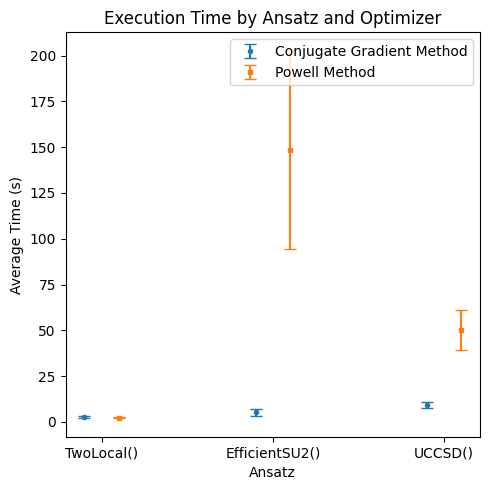

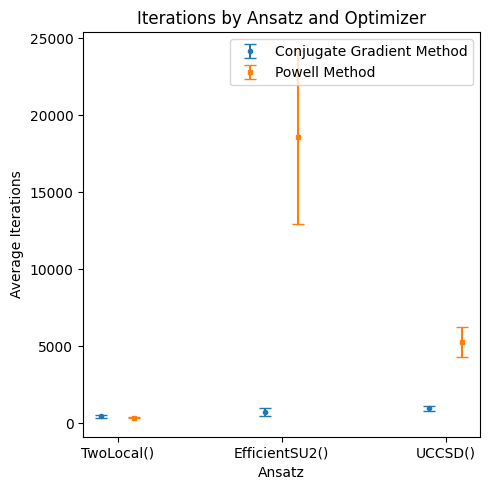

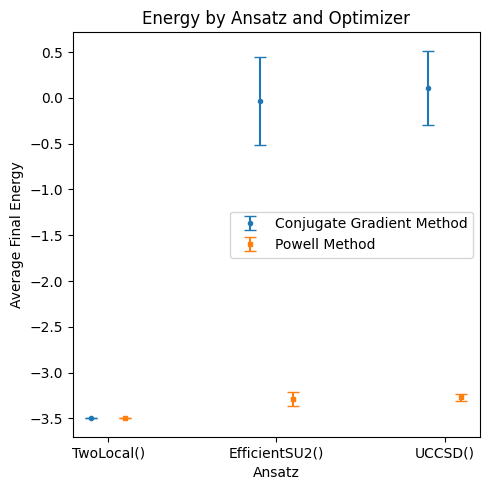

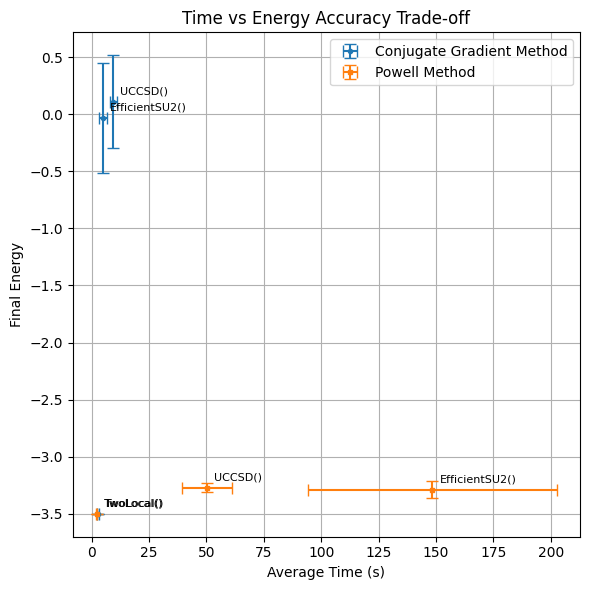

In [284]:
ansatze = ['TwoLocal()', 'EfficientSU2()', 'UCCSD()']
optimizers = ['Conjugate Gradient Method', 'Powell Method']
optimizer_markers = {'Conjugate Gradient Method': 'o', 'Powell Method': 's'}
colors = {'Conjugate Gradient Method': 'tab:blue', 'Powell Method': 'tab:orange'}

labels = [f'{a}-{o}' for a in ansatze for o in optimizers]

avg_times = np.array([average_time_1a,average_time_1b,average_time_2a,average_time_2b,average_time_3a,average_time_3b])
time_vars = np.array([var_time_1a,var_time_1b,var_time_2a,var_time_2b,var_time_3a,var_time_3b])
time_errs = np.sqrt(time_vars)

avg_iters = np.array([average_iter_1a,average_iter_1b,average_iter_2a,average_iter_2b,average_iter_3a,average_iter_3b])
iter_vars = np.array([var_iter_1a,var_iter_1b,var_iter_2a,var_iter_2b,var_iter_3a,var_iter_3b])
iter_errs = np.sqrt(iter_vars)

avg_energies = np.array([average_energy_1a,average_energy_1b,average_energy_2a,average_energy_2b,average_energy_3a,average_energy_3b])
energy_vars = np.array([var_energy_1a,var_energy_1b,var_energy_2a,var_energy_2b,var_energy_3a,var_energy_3b])
energy_errs = np.sqrt(energy_vars)

x_pos = np.arange(len(ansatze))

def plot_metric(y, yerr, ylabel, title):
    fig = plt.figure(figsize=(5,5))
    
    for i, opt in enumerate(optimizers):
        xs = x_pos + (-0.1 if i == 0 else 0.1) 
        ys = y[i::2]
        yerrs = yerr[i::2]
        plt.errorbar(xs, ys, yerr=yerrs, fmt=optimizer_markers[opt], 
                     color=colors[opt], label=opt, capsize=4, markersize=3)
    
    plt.xticks(x_pos, ansatze)
    plt.xlabel("Ansatz")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(title +".pdf", dpi=1000)

plot_metric(avg_times, time_errs, "Average Time (s)", "Execution Time by Ansatz and Optimizer")
plot_metric(avg_iters, iter_errs, "Average Iterations", "Iterations by Ansatz and Optimizer")
plot_metric(avg_energies, energy_errs, "Average Final Energy", "Energy by Ansatz and Optimizer")

fig = plt.figure(figsize=(6,6))
for i, opt in enumerate(optimizers):
    xs = avg_times[i::2]
    ys = avg_energies[i::2]
    xerrs = time_errs[i::2]
    yerrs = energy_errs[i::2]
    labels = ansatze
    plt.errorbar(xs, ys, xerr=xerrs, yerr=yerrs, fmt=optimizer_markers[opt],
                 color=colors[opt], capsize=4, label=opt, markersize=3,)
    for j in range(len(xs)):
        label = f"{ansatze[j]}"
        plt.annotate(label, (xs[j], ys[j]), textcoords="offset points", xytext=(5,5), fontsize=8)

plt.xlabel("Average Time (s)")
plt.ylabel("Final Energy")
plt.title("Time vs Energy Accuracy Trade-off")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("Time vs Energy Accuracy Trade-off" +".pdf", dpi=1000)